# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [41]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [40]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
if not os.path.exists(os.path.join(DATA_PATH, 'churchill.txt')):
    os.chdir(BASE_PATH)
    !cp churchill.txt /content
os.chdir('/content')

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # data = re.sub(r"\s+", " ", data)
    data = re.sub(r"\s", " ", data)
    # data = re.sub(r"[\n\t\s]", " ", data)
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    tokens = []
    # data = "abcdefghijklmnopqrstuvw" # test data
    label = 0
    for char in data:
        # voc2ind[char] = ord(char)
        if char not in voc2ind:
          voc2ind[char] = label
          label += 1
        tokens.append(voc2ind[char])

    print("voc2ind", len(voc2ind))
    ind2voc = {val: key for key, val in voc2ind.items()}

    nTrain = int(len(tokens) * 0.8)
    train_text = tokens[:nTrain] # TODO Fill this in
    test_text = tokens[nTrain:] # TODO Fill this in
    print("train len:", len(train_text), "test len:", len(test_text))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Alphabet(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

voc2ind 89
train len: 5000121 test len: 1250031


In [43]:
# Churchill dataset
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # data = re.sub(r"\s+", " ", data)
    data = re.sub(r"\s", " ", data)
    # data = re.sub(r"[\n\t\s]", " ", data)
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    tokens = []
    # data = "abcdefghijklmnopqrstuvw" # test data
    label = 0
    for char in data:
        # voc2ind[char] = ord(char)
        if char not in voc2ind:
          voc2ind[char] = label
          label += 1
        tokens.append(voc2ind[char])

    print("voc2ind", len(voc2ind))
    ind2voc = {val: key for key, val in voc2ind.items()}

    nTrain = int(len(tokens) * 0.8)
    train_text = tokens[:nTrain] # TODO Fill this in
    test_text = tokens[nTrain:] # TODO Fill this in
    print("train len:", len(train_text), "test len:", len(test_text))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'churchill_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'churchill_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'churchill.txt')

voc2ind 87
train len: 7480433 test len: 1870109


In [ ]:
# Word tokenization
from collections import Counter
def escape_data(data):
    data = re.sub(r"\"", " \" ", data)
    data = re.sub(r",", " , ", data)
    data = re.sub(r"\.", " . ", data)
    data = re.sub(r"\?", " ? ", data)
    data = re.sub(r"!", " ! ", data)
    data = re.sub(r":", " : ", data)
    data = re.sub(r";", " ; ", data)
    data = re.sub(r"\'", " \' ", data)
    data = re.sub(r"-", " - ", data)
    data = re.sub(r"\(", " \( ", data)
    data = re.sub(r"\)", " \) ", data)
    return data.lower().split()

def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = escape_data(data)
    occurances = Counter(data)
    # print(occurances)
    # data = re.sub(r"[\n\t\s]", " ", data)
    voc2ind = {'<unknown>':0}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    tokens = []
    label = 1
    unknowns = 0
    for word in data:
        # voc2ind[char] = ord(char)
        if occurances[word] < 5:
            tokens.append(voc2ind['<unknown>'])
            unknowns += 1
        else:
            if word not in voc2ind:
              voc2ind[word] = label
              label += 1
            tokens.append(voc2ind[word])
    print("data size", len(data))
    print("token size", len(tokens))
    print("num unknowns", unknowns)
    print("voc2ind", len(voc2ind))
    ind2voc = {val: key for key, val in voc2ind.items()}

    nTrain = int(len(tokens) * 0.8) 
    train_text = tokens[:nTrain] # TODO Fill this in
    test_text = tokens[nTrain:] # TODO Fill this in
    print("train len:", len(train_text), "test len:", len(test_text))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] + " " for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

data size 1439009
token size 1439009
num unknowns 23495
voc2ind 9007
train len: 1151207 test len: 287802


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        # self.vocab = Alphabet(data_file)
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.dataset = dataset["tokens"]
        # print(len(self.dataset))
        # print("dataset keys:", dataset.keys())
        if len(dataset) % self.batch_size != 0:
          self.dataset = self.dataset[:(len(self.dataset) // self.batch_size * self.batch_size)]
        
        # print("dataset length:", len(self.dataset))
        self.chunk_size = len(self.dataset) // self.batch_size
        self.seq_per_chunk = int(np.ceil((self.chunk_size - 1) / self.sequence_length))


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # print("__len__:", int(np.ceil((len(self.dataset) // self.batch_size - 1) / self.sequence_length) * self.batch_size))
        return self.seq_per_chunk * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        chunk_start_ind = idx % self.batch_size * self.chunk_size 
        # chunk_start_ind = idx // self.seq_per_chunk * self.chunk_size
        # print("chunk start index:", chunk_start_ind)
        # batch_start_ind = chunk_start_ind + (idx % self.seq_per_chunk) * self.sequence_length # start of data
        batch_start_ind = chunk_start_ind + idx // self.batch_size % self.seq_per_chunk # start of data
        # Find end index; includes extra character for labels
        if batch_start_ind + self.sequence_length + 1 > chunk_start_ind + self.chunk_size:
          batch_end_ind = chunk_start_ind + self.chunk_size  
        else:
          batch_end_ind = batch_start_ind + self.sequence_length + 1
        # print("start:end", batch_start_ind, ":", batch_end_ind)
        data = self.dataset[batch_start_ind:batch_end_ind]
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
# Testing part 3 code
# data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 10, 256)
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 4, 2)

print(data_train.__len__())
print(data_train.__getitem__(0))
print(data_train.__getitem__(1))
print(data_train.__getitem__(2))
print(data_train.__getitem__(3))
print(data_train.__getitem__(4))
print(data_train.__getitem__(5))

1250030
(tensor([0, 1, 2, 2]), tensor([1, 2, 2, 3]))
(tensor([13, 14, 15,  4]), tensor([14, 15,  4, 15]))
(tensor([1, 2, 2, 3]), tensor([2, 2, 3, 4]))
(tensor([14, 15,  4, 15]), tensor([15,  4, 15, 11]))
(tensor([2, 2, 3, 4]), tensor([2, 3, 4, 5]))
(tensor([15,  4, 15, 11]), tensor([ 4, 15, 11,  1]))


In [ ]:
# Testing part 3 code on word tokens
# data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 10, 256)
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', 4, 2)

print(data_train.__len__())
print(data_train.__getitem__(0))
print(data_train.__getitem__(1))
print(data_train.__getitem__(2))
print(data_train.__getitem__(3))
print(data_train.__getitem__(4))
print(data_train.__getitem__(5))

6500
(tensor([1, 2, 3, 4]), tensor([2, 3, 4, 5]))
(tensor([0, 0, 0, 0]), tensor([   0,    0,    0, 7556]))
(tensor([2, 3, 4, 5]), tensor([3, 4, 5, 6]))
(tensor([   0,    0,    0, 7556]), tensor([   0,    0, 7556, 7557]))
(tensor([3, 4, 5, 6]), tensor([4, 5, 6, 7]))
(tensor([   0,    0, 7556, 7557]), tensor([   0, 7556, 7557,    0]))


# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        # x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 1
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # outputs.append(output.argmax())
        outputs.append(output[0][1:].argmax()) # for word tokens
        data = outputs[-1].to(device)
        output, hidden = model.inference(data, hidden, temperature=TEMPERATURE)
    return outputs 
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # outputs.append(torch.multinomial(output, 1))
        outputs.append(torch.multinomial(output[0][1:], 1)) # for word tokens
        data = outputs[-1].to(device)
        output, hidden = model.inference(data, hidden, temperature=TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # 1. Initialize the beam list with the single existing empty beam
    # 2. Repeat for the sequence length:
    for ii in range(sequence_length):
        temp = []
        for b in beam:
    #     1. For each beam in the beam list:
    #         1. Compute the next distribution over the output space for that state
    #         2. Sample from the distribution with replacement
            sample = torch.multinomial(b[1][0][1:], beam_width, replacement=True) # for word tokens
            # sample = torch.multinomial(b[1][0], beam_width, replacement=True)
    #         3. For each sample:
            for n in sample:
    #             1. Compute its score
                score = b[3] + b[1][0][n]
                sequence = b[0].copy() # .detach().clone()?
                # sequence.append(n)
                sequence.append(n)
                data = sequence[-1].to(device)
                hidden = b[2].to(device)
                # hidden_state = b[2][0].to(device) # for LSTM
                # cell_state = b[2][1].to(device) # for LSTM
                # hidden = (hidden_state, cell_state) # for LSTM
                output, hidden = model.inference(data, hidden, temperature=TEMPERATURE)
    #             2. Record its hidden state and chosen value
                temp.append((sequence, output, hidden, score))
    #         4. Add all the samples to the new beam list      
    #     2. Rank the new beam list
        temp.sort(key=lambda x: x[3], reverse=True)
    #     3. Throw out all but the top N beams
        beam = temp[:beam_width]
    # 3. Return the top beam's chosen values.
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        # seed_words_arr = vocab.words_to_array(seed_words)
        seed_words_arr = vocab.words_to_array(escape_data(seed_words)) # for word tokenization
        # print("seed words array", seed_words_arr)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
            # print("output shape", output.shape)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [ ]:
# Testing part 5 code
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 10, 256)

vocab = data_train.vocab

# print("cuda is available", torch.cuda.is_available())
# device = torch.device("cpu")
device = torch.device("cuda")

model = HarryPotterNet(data_train.vocab_size(), 512).to(device)

seed_words = 'The'

generated_sentence = generate_language(model, device, seed_words, 10, vocab, 'beam') #can replace sample with whatever method you want to test

print("generate", generated_sentence)

generate The~-z.bNNff=


In [ ]:
# Testing part 5 code for word  tokenization
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', 10, 256)

vocab = data_train.vocab

# print("cuda is available", torch.cuda.is_available())
# device = torch.device("cpu")
device = torch.device("cuda")

model = HarryPotterNet(data_train.vocab_size(), 512).to(device)

seed_words = 'The world!'

generated_sentence = generate_language(model, device, seed_words, 10, vocab, 'max') #can replace sample with whatever method you want to test

print("generate", generated_sentence)

generate the world ! desks muttered mopping map 17 generations foot twelfth bluntly banged 


# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    print('\nPerplexity\n', np.exp(test_loss))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
lstm.weight_ih_l1 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l1 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l1 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l1 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/hw2/logs/0.17/checkpoints/020.pt
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edge of the rock and plunged 

  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.6074, Accuracy: 784515/1433600 (55%)


Perplexity
 4.989809384695642


  0%|          | 0/25 [00:00<?, ?it/s]


Interrupted
Saving final model
Saved /gdrive/My Drive/colab_files/hw2/logs/0.17/checkpoints/020.pt



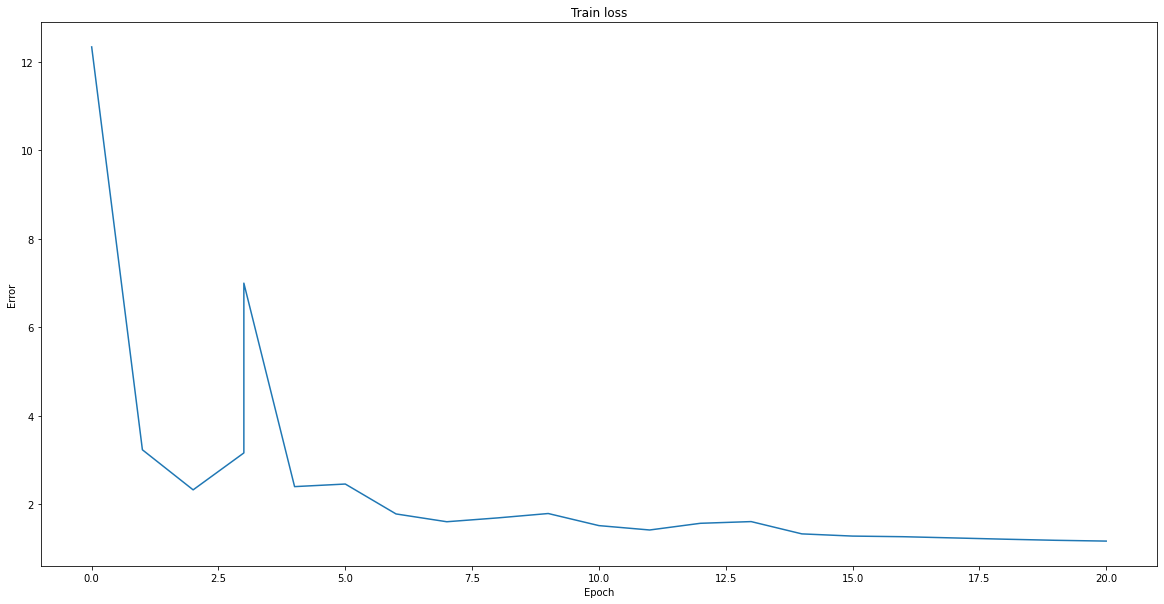

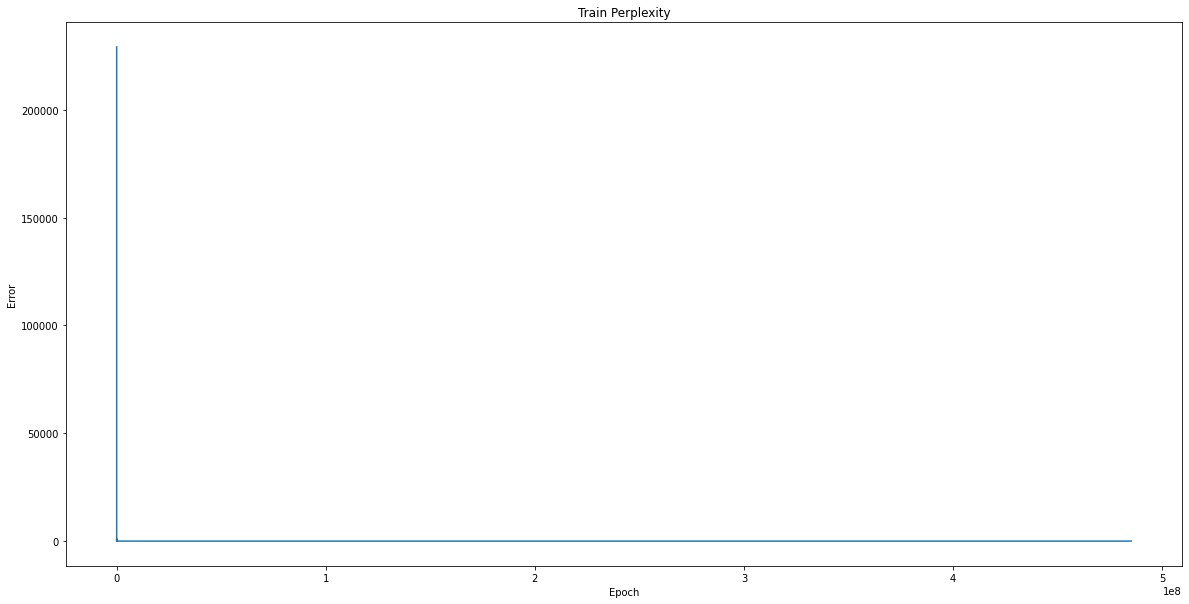

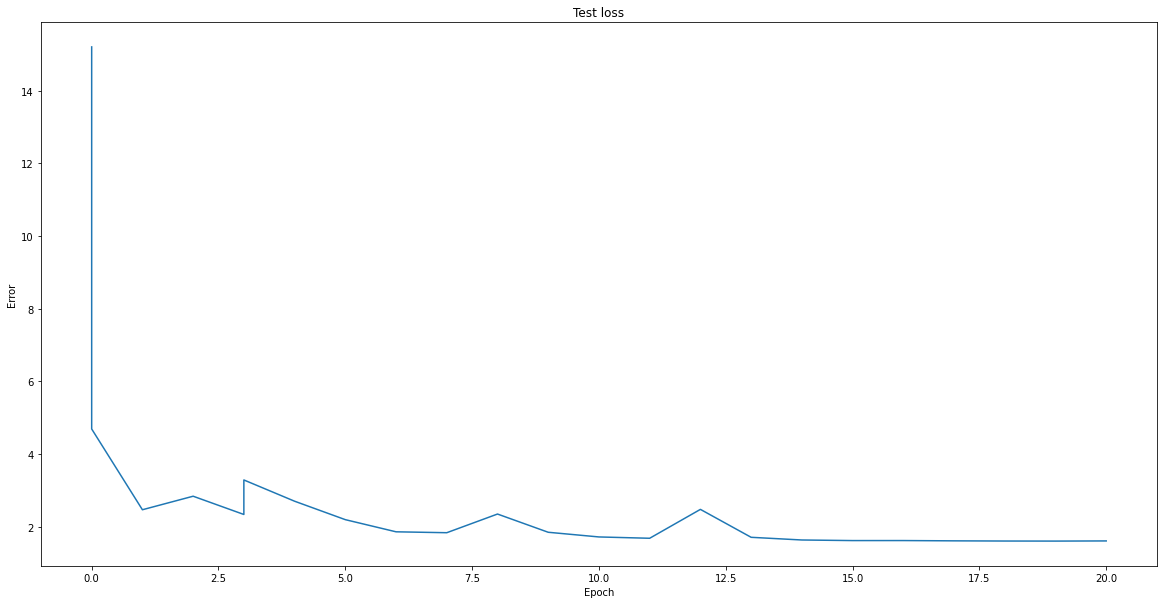

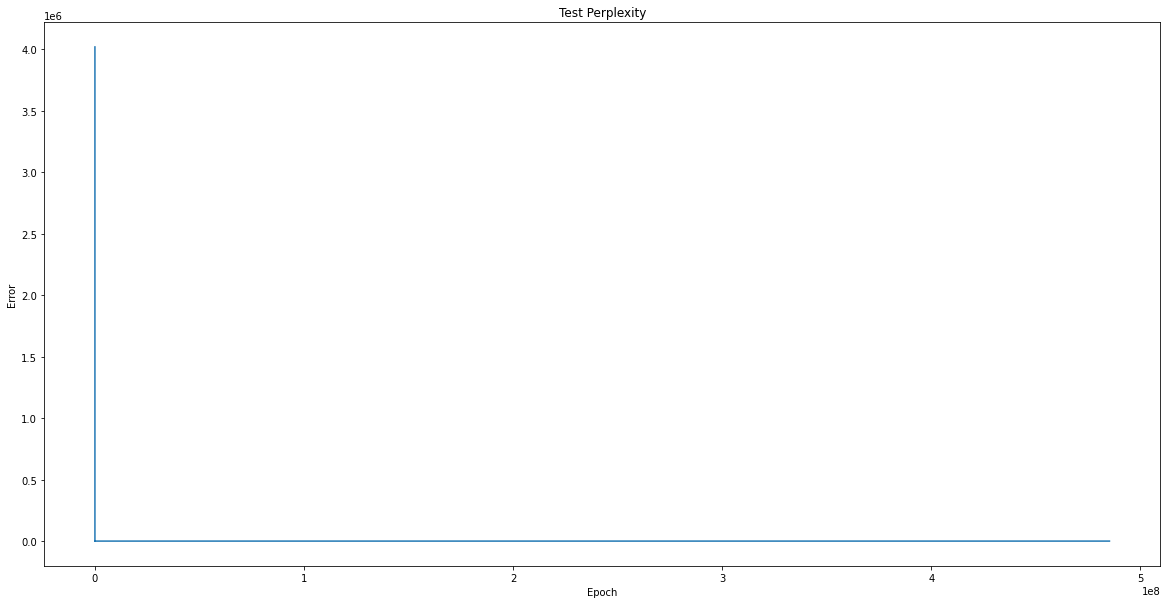

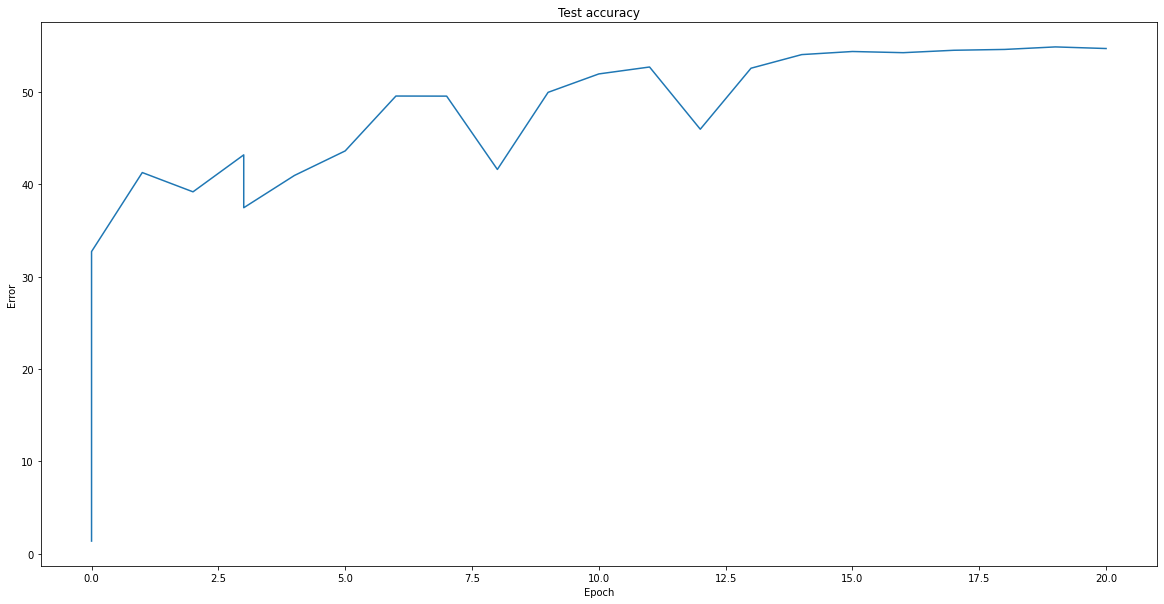

In [ ]:
def main():
    SEQUENCE_LENGTH = 800
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    EXPERIMENT_VERSION = "0.17"
    LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
    LOG_FILE = "log.pkl"

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + LOG_FILE, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + LOG_FILE, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*np.exp(train_losses))
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*np.exp(test_losses))
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2
Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	pillowcase baubles summer comical towards misery thundering wastepaper werewolves perch warning magnificently lament everythin leading insisted maliciously sensed tle thundering gazed voiced hem blaze snatched legilimens snatched hippogriff enforcement maze defenses department contorted conquer strongly translation improving deliberately thestral encouragingly momentarily sensed perched swish jeers alerted lurching everlasting see thwarted 




  0%|          | 0/45 [00:00<?, ?it/s]

Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he approached 
pred	slunk magnificently spoke winding leading insisted maliciously sensed tle thundering gazed voiced hem blaze snatched legilimens snatched hippogriff enforcement maze defenses department contorted conquer strongly translation improving deliberately thestral encouragingly momentarily sensed perched swish jeers alerted lurching everlasting see thwarted maliciously snatched fortunately handled signs panicked bookcases lengths appeal scattered 



Test set: Average loss: 25.2597, Accuracy: 14/307200 (0%)


Perplexity
 93358672290.1

  2%|▏         | 1/45 [00:00<00:18,  2.37it/s]

Train Epoch: 0 [0/23040 (0%)]	Loss: 25.146797


 24%|██▍       | 11/45 [00:03<00:11,  2.94it/s]

Train Epoch: 0 [5120/23040 (22%)]	Loss: 11.942021


 47%|████▋     | 21/45 [00:07<00:08,  2.92it/s]

Train Epoch: 0 [10240/23040 (44%)]	Loss: 7.935294


 69%|██████▉   | 31/45 [00:10<00:04,  2.89it/s]

Train Epoch: 0 [15360/23040 (67%)]	Loss: 6.431673


 91%|█████████ | 41/45 [00:14<00:01,  2.87it/s]

Train Epoch: 0 [20480/23040 (89%)]	Loss: 5.731916


100%|██████████| 45/45 [00:15<00:00,  2.90it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	painful selected back back back back menacing was too . harry ' ' ' to his . " he he ' don don don <unknown> . <unknown> <unknown> <unknown> " harry harry . , and at at at the ' . master he he he the of he he entire 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry 

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . crest whooshing and oliver , potter dursley , <unknown> , and walls was that was ! saying " shuddered overcome . later , walls , harry and trials , spent , potter and briskly , walls pinned , symbols , <unknown> and scruff was ho , as drills and was <unknown> incredibly , walls , because beak , desperation , proven dursley , nonsense potter , potter , potter , walls and was paused , <unknown> was there was was out , there was tearing , potter , wanted , and urged , , walls and spent , and caves was and sloped , johnson and mysterious ll so dursley , and discover , hater and reporter , skulls , walls , as deeply , and discover twist , counter seeker countryside potter dursley , walls , and and was crime , spent , forgetting and nonsense throb ' ' ' ' ' ' ' ' ' ' ' ' ' didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn didn child fine cried paint resort disco

  2%|▏         | 1/45 [00:00<00:21,  2.04it/s]

Train Epoch: 1 [0/23040 (0%)]	Loss: 5.790575


 24%|██▍       | 11/45 [00:03<00:12,  2.79it/s]

Train Epoch: 1 [5120/23040 (22%)]	Loss: 4.153566


 47%|████▋     | 21/45 [00:07<00:08,  2.78it/s]

Train Epoch: 1 [10240/23040 (44%)]	Loss: 3.398915


 69%|██████▉   | 31/45 [00:11<00:05,  2.75it/s]

Train Epoch: 1 [15360/23040 (67%)]	Loss: 3.336245


 91%|█████████ | 41/45 [00:14<00:01,  2.72it/s]

Train Epoch: 1 [20480/23040 (89%)]	Loss: 3.548127


100%|██████████| 45/45 [00:16<00:00,  2.75it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar ron ron . to to he ' <unknown> punched harry ' ' patches to his . " harry harry ' been , <unknown> " . <unknown> <unknown> <unknown> " harry harry . . and at at at the look of " he of he the <unknown> he he entire 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harr

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . throwing remains and discover realize shape was tempered , better , and greatest <unknown> , which <unknown> tin , <unknown> " and <unknown> dursley , <unknown> dursley , and say useful mr dursley coach pansy , p apron dursley , entire dursley , , career , secretary , contemptuously , right ignorant , hermione and dursley , avoiding , as daylight and as daylight and noticed say markings winds word , lived mr mr mr mr reflecting reflecting and and out , hermione , middle , and that <unknown> , right , mysterious , potter dursley , <unknown> , and secretary , stair , diggory chance seen and was grunted and sweating <unknown> <unknown> breaths and bumped none , them discover , walls , and realize was sleepy narrowed mr mr mr reflecting reflecting and and out , useful referring familiar , useful mr mr mr mr reflecting and raging out , potter , potter potter , walls , you saying dursley , we will dug . <unknown> an

  2%|▏         | 1/45 [00:00<00:20,  2.14it/s]

Train Epoch: 2 [0/23040 (0%)]	Loss: 4.128159


 24%|██▍       | 11/45 [00:04<00:12,  2.77it/s]

Train Epoch: 2 [5120/23040 (22%)]	Loss: 2.493707


 47%|████▋     | 21/45 [00:07<00:08,  2.76it/s]

Train Epoch: 2 [10240/23040 (44%)]	Loss: 1.787141


 69%|██████▉   | 31/45 [00:11<00:05,  2.76it/s]

Train Epoch: 2 [15360/23040 (67%)]	Loss: 1.872988


 91%|█████████ | 41/45 [00:14<00:01,  2.74it/s]

Train Epoch: 2 [20480/23040 (89%)]	Loss: 2.350339


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar ron dried . to to he ' unfortunately punched harry ' ' me to homework . harry harry harry ' been at they " on very <unknown> <unknown> harry harry harry . . and at at at the shabby of presented there of he the <unknown> apparated he entire 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait -

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . throw confiscated locket wrenching and <unknown> exercise heated , career mr mr reflecting and and out , out , walls , potter allowed involved involved warned involved turban glimpses potter dursley , " pen , " mirror t hair , and realize held quickly mr mr mr reflecting and and and out , useful cormac , hermione , <unknown> , as <unknown> , and <unknown> <unknown> , and that <unknown> , discover , hermione , because and was inspired beady national real sworn dursley , , useful mr mr mr mr ourselves mr ourselves ours , out , started standing mr mr mr ourselves mr out , out , useful was mr mr mr ourselves out , useful , potter out , potter trouble vane window , potter young , potter , hermione as screamed sacks , <unknown> walls , <unknown> and line , mysterious , mysterious dursley , thank , you 11 panted morale dursley , around drills mr mr mr ourselves mr mr ourselves ours out , , . gingerly , potter useful 

  2%|▏         | 1/45 [00:00<00:20,  2.15it/s]

Train Epoch: 3 [0/23040 (0%)]	Loss: 3.177586


 24%|██▍       | 11/45 [00:03<00:11,  2.84it/s]

Train Epoch: 3 [5120/23040 (22%)]	Loss: 1.480517


 47%|████▋     | 21/45 [00:07<00:08,  2.85it/s]

Train Epoch: 3 [10240/23040 (44%)]	Loss: 0.938029


 69%|██████▉   | 31/45 [00:10<00:04,  2.83it/s]

Train Epoch: 3 [15360/23040 (67%)]	Loss: 1.053411


 91%|█████████ | 41/45 [00:14<00:01,  2.81it/s]

Train Epoch: 3 [20480/23040 (89%)]	Loss: 1.738117


100%|██████████| 45/45 [00:15<00:00,  2.82it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar ron back . to to he was full punched harry gave ' me to full on on on harry was at conquer to to on very very on harry harry harry and . the at at at the shabby of of presented of as the hopkirk - somethin unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said 

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . vengeance menacing puffy potter happier and spent and vengeance realize 5 <unknown> fastened useful mr mr mr reflecting and drills , <unknown> , and out , and was keeled though introduce , was thwarted positively , so discover aim , disappearance and parkinson pleasantly marked and carefully dursley , riddle left and <unknown> and carefully out like , slam useful preparations , potter potter young , potter granger young , drills , <unknown> and nonsense regulus , hold nonsense , nonsense , nonsense nonsense , daylight ted nonsense mr mr mr reflecting and and and eyes rumbled middle of discover , hogsmeade , discover stooped , discover , gerroff , platform , upright and down and windowsill involved mmm fred stirring queen asleep beady useful dungeon mr mr mr ourselves mr mr ourselves clutches irritated , , . walls , involved involved involved storming pen malicious spiral mound contented involve , and drills , 

  2%|▏         | 1/45 [00:00<00:21,  2.01it/s]

Train Epoch: 4 [0/23040 (0%)]	Loss: 2.544903


 24%|██▍       | 11/45 [00:04<00:12,  2.78it/s]

Train Epoch: 4 [5120/23040 (22%)]	Loss: 0.968886


 47%|████▋     | 21/45 [00:07<00:08,  2.79it/s]

Train Epoch: 4 [10240/23040 (44%)]	Loss: 0.621431


 69%|██████▉   | 31/45 [00:11<00:05,  2.76it/s]

Train Epoch: 4 [15360/23040 (67%)]	Loss: 0.682195


 91%|█████████ | 41/45 [00:14<00:01,  2.74it/s]

Train Epoch: 4 [20480/23040 (89%)]	Loss: 1.154338


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled back . to like he monitored full full full gave ' the to leave on " on that mean no conquer to to would to hiss <unknown> harry harry harry , , the at at at the perfectly of of presented of of the ! - who unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! "

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . report raise memories hold bless , and intensified , suit and echoed baron <unknown> , and mousy nonsense intruders rods size house nonsense mr mr ourselves dursley , , , " wanted , drills , <unknown> and greatest , <unknown> , " council , and partially , amount , harry hepzibah , potter dursley , , so he think as drills , mr mr mr ourselves mr mr mr reflecting out , , potter , , walls , potter out , appearance , favor mind trouble and discover , toe , sorcerer , and throb . <unknown> touchy , frayed to send and was breakout invitation gossip out , called defiant , and but there hold hold mr mr potter um dursley , and aged thought deluded mr mr mr reflecting and and flashed out , discover , easily praise , torturing and ward trunk didn sorcerer sorcerer ard saying portion dursley , , we elves and double recited murmuring and poisonous pressed married proud proud proud proud proud proud proud proud proud panick

  2%|▏         | 1/45 [00:00<00:21,  2.08it/s]

Train Epoch: 5 [0/23040 (0%)]	Loss: 1.998865


 24%|██▍       | 11/45 [00:03<00:12,  2.82it/s]

Train Epoch: 5 [5120/23040 (22%)]	Loss: 0.689243


 47%|████▋     | 21/45 [00:07<00:08,  2.83it/s]

Train Epoch: 5 [10240/23040 (44%)]	Loss: 0.497563


 69%|██████▉   | 31/45 [00:11<00:04,  2.81it/s]

Train Epoch: 5 [15360/23040 (67%)]	Loss: 0.530016


 91%|█████████ | 41/45 [00:14<00:01,  2.79it/s]

Train Epoch: 5 [20480/23040 (89%)]	Loss: 0.889822


100%|██████████| 45/45 [00:16<00:00,  2.79it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled innumerable and and and he was full full harry full gave me to leave , " leave , don no , limbs don would alas harry harry " harry harry , , i at wand at the perfectly of " of of without hermione permanently - who unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - agua

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . glance national dursley , tents as and surface , potter potter dursley dursley , albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus thinking thinking thinking kidney thinking thinking thinking mustache mustache spying euphoria right years , harry harry potter dursley , , walls , " mirror dursley , albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus albus thinking thinking thinking kidney guess thinking harry mustache , and harry guffawed tend , amount , harry potter dursley , , , so dursley , so aim dursley , as both , potter dursley dursley , <unknown> still dursley , started biding <unknown> dudley dursley dursley , , walls dr

  2%|▏         | 1/45 [00:00<00:22,  1.92it/s]

Train Epoch: 6 [0/23040 (0%)]	Loss: 1.900405


 24%|██▍       | 11/45 [00:04<00:12,  2.81it/s]

Train Epoch: 6 [5120/23040 (22%)]	Loss: 0.665295


 47%|████▋     | 21/45 [00:07<00:08,  2.82it/s]

Train Epoch: 6 [10240/23040 (44%)]	Loss: 0.491217


 69%|██████▉   | 31/45 [00:11<00:05,  2.80it/s]

Train Epoch: 6 [15360/23040 (67%)]	Loss: 0.509122


 91%|█████████ | 41/45 [00:14<00:01,  2.76it/s]

Train Epoch: 6 [20480/23040 (89%)]	Loss: 0.775120


100%|██████████| 45/45 [00:16<00:00,  2.78it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled innumerable . " warrington he monitored full full harry full the the to leave on " on it mean no , paint paint harry harry harry harry " harry harry , . the at wand at the other of of presented of as the whole - who unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - ag

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . flooded er good good met hold longest was mr mr mr potter potter dursley , , and cormac , walls , and <unknown> discover , drive , thief dursley , as drills , <unknown> , and and kissed soul dursley , walls was neighbor <unknown> sorcerer and imitated mclaggen hopped mr mr mr mr ourselves mr strings out inter and birds , so werewolves that that <unknown> somebody free stooped , son , son , son , , son , sick , son dursley , son , walls burn hold disapparate and brutal holly burn hold mr mr mr mr mr reflecting potter dursley , , drills , walls , and discover , toe , faster dursley , , drills , land and loss offices found land squeakily whiskey and <unknown> hourglass mr mr mr ourselves mr mr mr reflecting dursley , , , walls , discover nonsense discover put happening mr mr ourselves mr mr mr reflecting reflecting and out , and discover , toe discover , serious , drills , , walls , you laughs and dursley trunk b

  2%|▏         | 1/45 [00:00<00:21,  2.00it/s]

Train Epoch: 7 [0/23040 (0%)]	Loss: 1.523996


 24%|██▍       | 11/45 [00:04<00:12,  2.79it/s]

Train Epoch: 7 [5120/23040 (22%)]	Loss: 0.510819


 47%|████▋     | 21/45 [00:07<00:08,  2.79it/s]

Train Epoch: 7 [10240/23040 (44%)]	Loss: 0.422441


 69%|██████▉   | 31/45 [00:11<00:05,  2.78it/s]

Train Epoch: 7 [15360/23040 (67%)]	Loss: 0.443595


 91%|█████████ | 41/45 [00:14<00:01,  2.76it/s]

Train Epoch: 7 [20480/23040 (89%)]	Loss: 0.656020


100%|██████████| 45/45 [00:16<00:00,  2.76it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled face . " " he monitored imprisoning full harry full the the leaky leave a " so that don no , paint very harry alas very harry harry harry harry immobile . the at wand at the other of " presented presented without the first - who unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - 

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . overwhelming was w tree complaints and vanished and say say it dursley , staggering somebody driven and cuffs sleep rear accord and flitted hangings <unknown> and nightcap him and right surrounding dursley , was and albus albus pounded albus albus proud proud proud proud proud proud proud proud cupboard cupboard that nonsense that grudge rug sweating and sweating aura stretch de eager and and pour though picked legs drive into and <unknown> say say it dursley , , thank thank that that that that that that that drive drive drive drive drive hey dursley , , ones shape , , pin , pin hallway young and funny funny and though comprehension fields comprehension distance young drive drive dursley , drills , window , window young international announced dursley , , spots , ways down dursley , , and aquiver kinder , discover , mother ' ' ' dursley dursley , cannons elves and picked fact drive indignation dursley nonsense

  2%|▏         | 1/45 [00:00<00:21,  2.06it/s]

Train Epoch: 8 [0/23040 (0%)]	Loss: 1.436608


 24%|██▍       | 11/45 [00:03<00:12,  2.83it/s]

Train Epoch: 8 [5120/23040 (22%)]	Loss: 0.493166


 47%|████▋     | 21/45 [00:07<00:08,  2.81it/s]

Train Epoch: 8 [10240/23040 (44%)]	Loss: 0.418907


 69%|██████▉   | 31/45 [00:11<00:04,  2.81it/s]

Train Epoch: 8 [15360/23040 (67%)]	Loss: 0.440171


 91%|█████████ | 41/45 [00:14<00:01,  2.77it/s]

Train Epoch: 8 [20480/23040 (89%)]	Loss: 0.606076


100%|██████████| 45/45 [00:16<00:00,  2.79it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled face . " " he was imprisoning full harry full the the leaky leave on " on it think it , paint paint to alas very <unknown> " harry harry , . ron at wand at the other of " of of without the footsteps - yelled unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti 

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . he excitedly and was suit rack out , and ride , and neither dursley , so telling say say it dursley , walls it nonsense and was trepidation that which albus albus albus albus albus proud proud proud proud proud proud lettering stretching harpies was was tucked hillside de protecting and de pour though yelped zoo mr mr like and was so anti and and because discover , stooped , because smugness around unforgivable , wizengamot down mr mr mr mr potter dursley , , , and , was woke woke clamped this and and realize prickling have even roar , nonsense nonsense feast potter potter young young , drills hold , potter , allowed , and , manner , <unknown> rein bit , useful , right <unknown> , <unknown> and <unknown> dursley , <unknown> was separately <unknown> useful , markings dursley , " speck bank yorkshire and nonsense prey calming boiling , nonsense nonsense potter , potter , flitwick , pattern , harry potter young a

  2%|▏         | 1/45 [00:00<00:21,  2.03it/s]

Train Epoch: 9 [0/23040 (0%)]	Loss: 1.318358


 24%|██▍       | 11/45 [00:04<00:12,  2.80it/s]

Train Epoch: 9 [5120/23040 (22%)]	Loss: 0.473457


 47%|████▋     | 21/45 [00:07<00:08,  2.82it/s]

Train Epoch: 9 [10240/23040 (44%)]	Loss: 0.410946


 69%|██████▉   | 31/45 [00:11<00:05,  2.79it/s]

Train Epoch: 9 [15360/23040 (67%)]	Loss: 0.430584


 91%|█████████ | 41/45 [00:14<00:01,  2.77it/s]

Train Epoch: 9 [20480/23040 (89%)]	Loss: 0.580927


100%|██████████| 45/45 [00:16<00:00,  2.78it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled face . " " he was imprisoning full finds gave the the tle foe . " on that think no , to to to the " <unknown> " harry harry , . " at wand at the other of " there important without the name somethin yelled unnecessary 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! "

  0%|          | 0/45 [00:00<?, ?it/s]

generated beam		 harry potter , voldemort , and dumbledore walk into a bar . excitedly 5 window , whipped and bits medieval and drip instantly and chanced dursley dursley , loathed loathed tongue remain dursley , and nonsense eyes attempted nonsense drive dursley , nonsense flowered screaming low dursley dursley , whether yorkshire , hopes and nonsense dursley of and to prompted desperate pour drawing dursley , right finest detected crossing lifeless years , happens folded and and and realize and followed zigzagged would mr um dursley , thank thank thank that that that that that that that family albus picked realize pressed atrium evening nonsense , nonsense bear thinking , albus albus albus plot grapefruit mr mr mr potter dursley , , walls , and and discover , deliberately , excitedly dursley , sneaked panic backfired bark aim ' timetable above poking onlookers dursley , head and . waiting jones albus albus albus albus albus proud proud proud proud proud proud proud lettering stretchi

  2%|▏         | 1/45 [00:00<00:21,  2.05it/s]

Train Epoch: 10 [0/23040 (0%)]	Loss: 1.450707


 24%|██▍       | 11/45 [00:03<00:12,  2.81it/s]

Train Epoch: 10 [5120/23040 (22%)]	Loss: 0.531418


 47%|████▋     | 21/45 [00:07<00:08,  2.81it/s]

Train Epoch: 10 [10240/23040 (44%)]	Loss: 0.443140


 69%|██████▉   | 31/45 [00:11<00:05,  2.80it/s]

Train Epoch: 10 [15360/23040 (67%)]	Loss: 0.456635


 91%|█████████ | 41/45 [00:14<00:01,  2.77it/s]

Train Epoch: 10 [20480/23040 (89%)]	Loss: 0.580565


100%|██████████| 45/45 [00:16<00:00,  2.77it/s]


Input	glass to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear 
GT	to his lips - - but it was empty . dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> 
pred	jar fooled life and " " he was imprisoning devastated harry gave the the neck foe on " so his don nightfall , to to to the " <unknown> " harry harry had . " " mouth at the responsibility without " there important without a first , somethin view 


Input	. dumbledore groaned and began to <unknown> . " but i had some - - wait - - aguamenti ! " said harry again , pointing his wand at the goblet . once more , for a second , clear <unknown> - ter gleamed within it , but as he 
GT	dumbledore groaned and began to <unknown> . " but i had some - - wait 

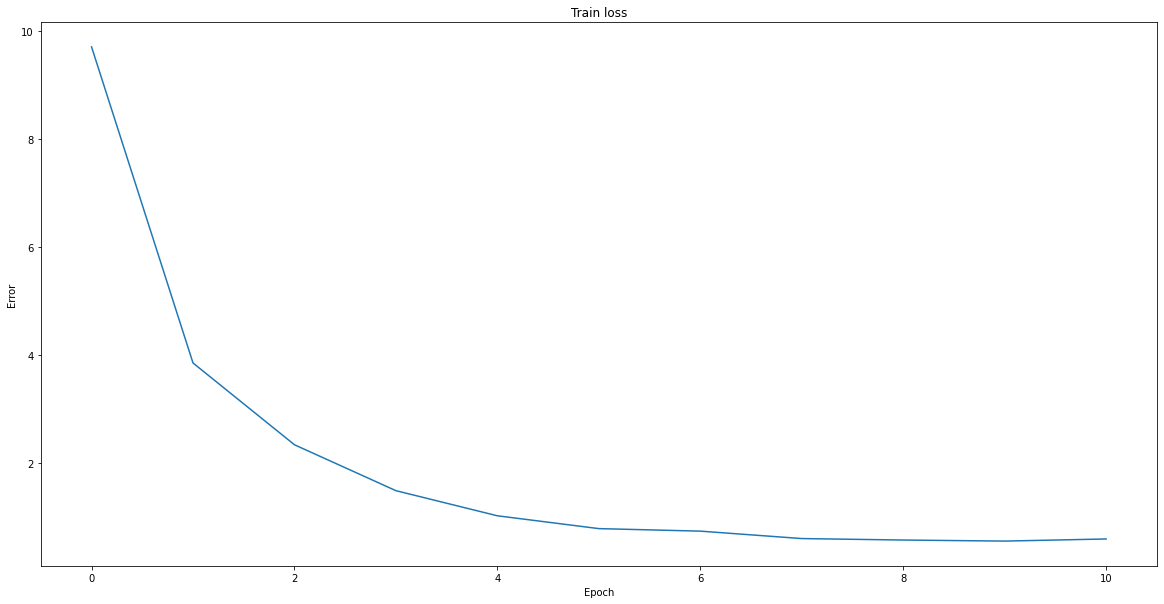

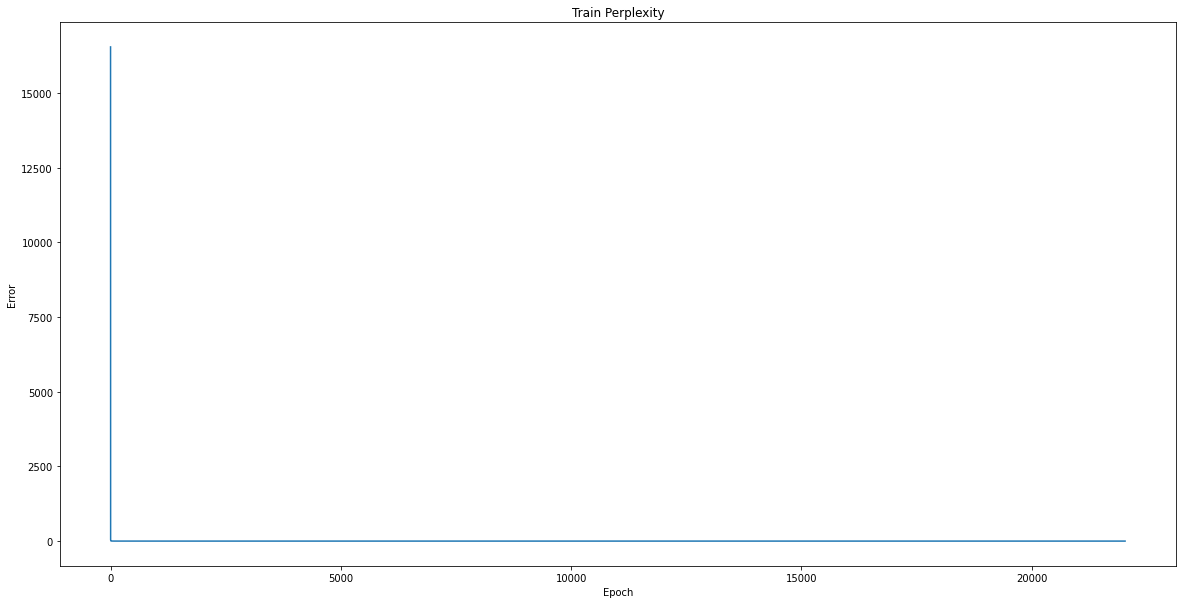

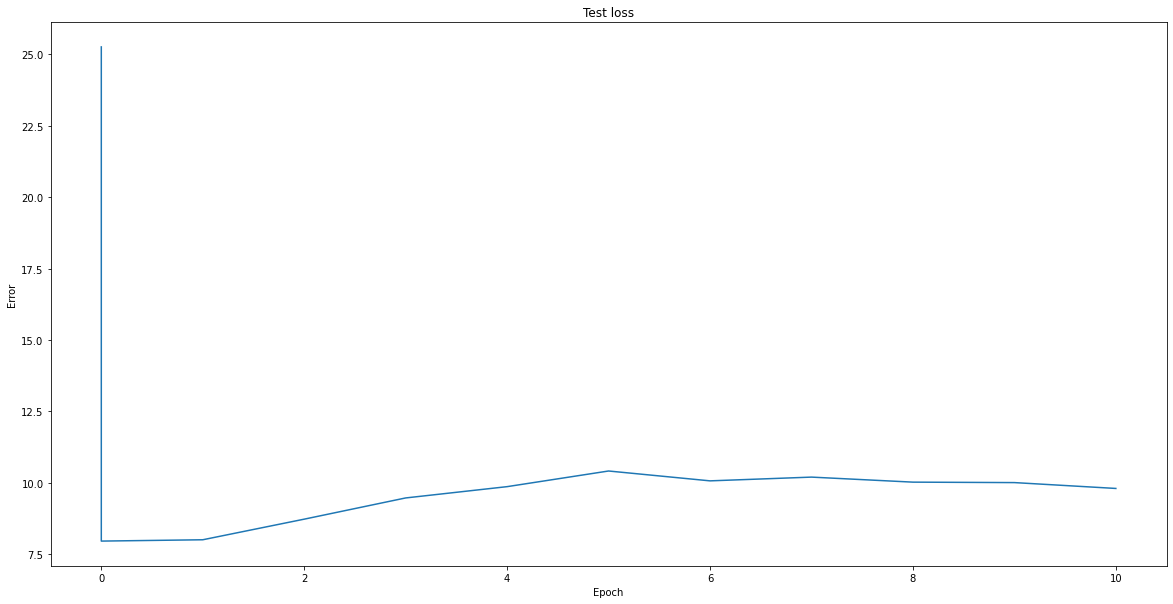

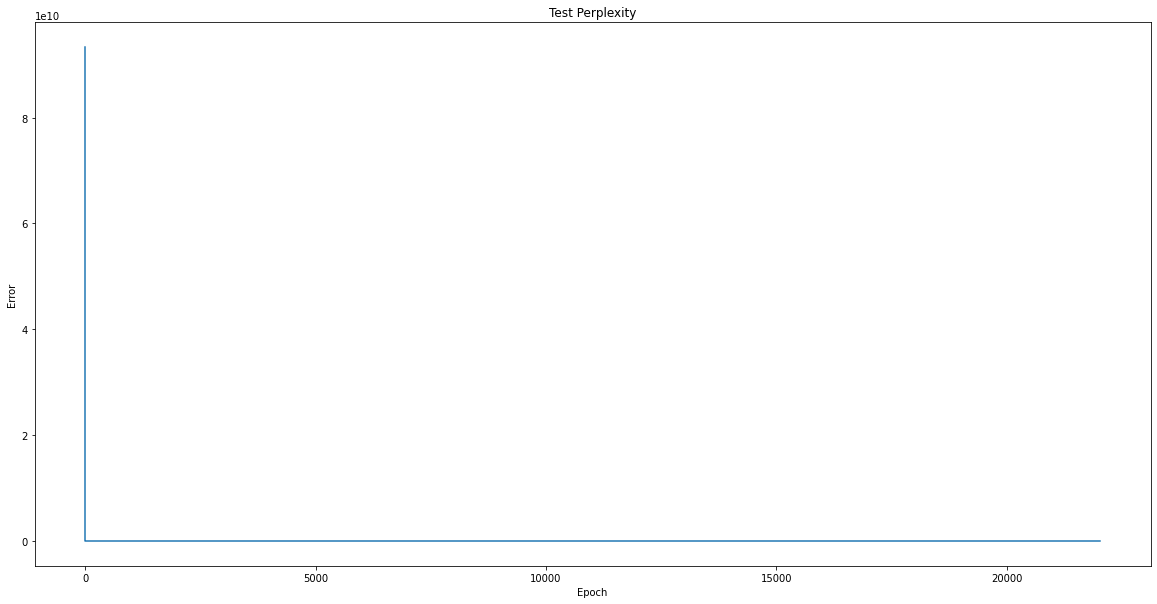

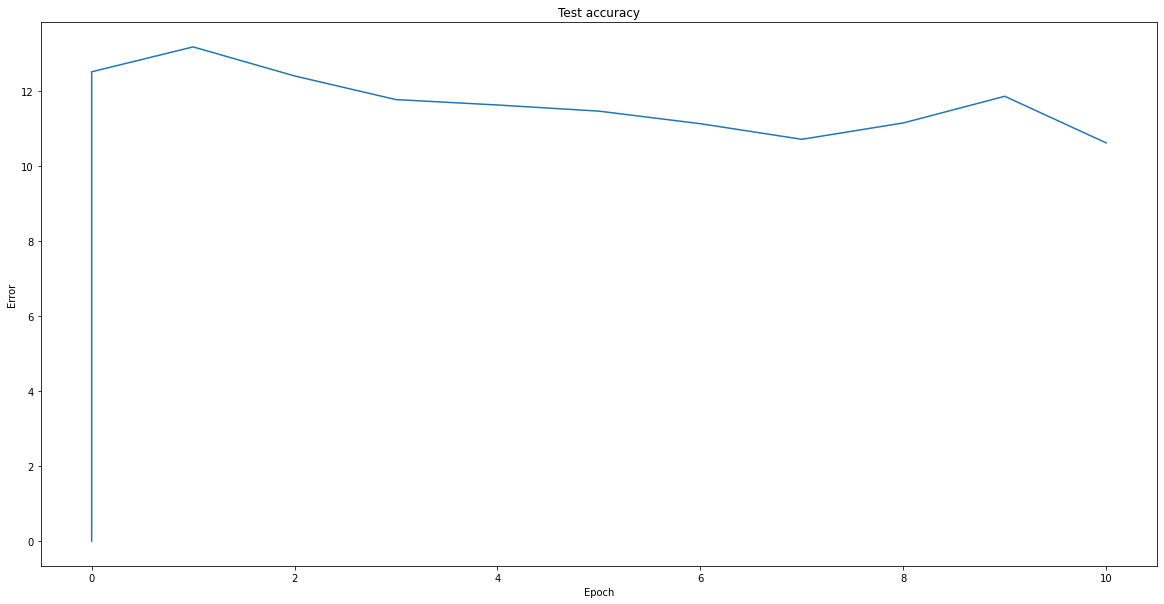

In [ ]:
# Word tokenization training
def main():
    SEQUENCE_LENGTH = 50
    BATCH_SIZE = 512
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 512
    EPOCHS = 10
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    EXPERIMENT_VERSION = "1.8"
    LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
    LOG_FILE = "log.pkl"

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + LOG_FILE, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + LOG_FILE, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*np.exp(train_losses))
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*np.exp(test_losses))
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = ' Voldemort is like a teenage girl. '
    sequence_length = 30

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 voldemort is like a teenage girl . opinion that that and simple moving and and that drive drive nonsense nonsense dursley dursley sorcerer <unknown> , <unknown> window met met good proud potter potter young mr mr mr 
generated with sample	 voldemort is like a teenage girl . opinion sniff that and host slit proud because vengeance proud proud mr mr mr mr mr mr mr mr mr mr mr mr mr mr mr mr mr mr mr 
generated with sample	 voldemort is like a teenage girl . opinion too and and and discover moving proud proud and was and common say blonde proud proud cold mr mr mr mr mr mr mr mr mr mr mr mr 
generated with sample	 voldemort is like a teenage girl . opinion secret and and azkaban proud proud hold hold was dursley spent balding was was alive out , potter dursley useful useful sloper and paused chestnut woke guests glowing flying 
generated with sample	 voldemort is like a teenage girl . opinion that that hesitated squeak and simple and blonde nonsense mr mr mr mr mr mr m

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters. 

For my best model, I used an LSTM with 2 layers (network architecture code shown below) and the following hyper parameters:
* TEMPERATURE = 1
* BEAM_WIDTH = 10
* SEQUENCE_LENGTH = 800
* BATCH_SIZE = 256
* FEATURE_SIZE = 512
* TEST_BATCH_SIZE = 256
* EPOCHS = 20
* LEARNING_RATE = 0.002
* WEIGHT_DECAY = 0.0005

```
def __init__(self, vocab_size, feature_size):
      super(HarryPotterNet, self).__init__()
      self.vocab_size = vocab_size
      self.feature_size = feature_size
      self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
      self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
      self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
      self.decoder = nn.Linear(self.feature_size, self.vocab_size)
      
      # This shares the encoder and decoder weights as described in lecture.
      self.decoder.weight = self.encoder.weight
      self.decoder.bias.data.zero_()
      
      self.best_accuracy = -1
    
def forward(self, x, hidden_state=None):
      batch_size = x.shape[0]
      sequence_length = x.shape[1]
      
      # TODO finish defining the forward pass.
      # You should return the output from the decoder as well as the hidden state given by the gru.
      x = self.encoder(x)
      # x, hidden_state = self.gru(x, hidden_state)
      x, hidden_state = self.lstm(x, hidden_state)
      x = self.decoder(x)
      return x, hidden_state
```   
    
See the plots for training loss, training perplexity, test loss, test perplexity, and test accuracy below: 

![Training loss plot](https://drive.google.com/uc?id=1ggUrVPNcVs1zL6aSzq21EpgshPY7Baph)

![Training perplexity plot](https://drive.google.com/uc?id=1zce5R7Zc-ETh-UAxg_27GOGRuSPcxSFy)

![Test loss plot](https://drive.google.com/uc?id=1XgsdMMLRJIv2DoxewXtCHyPBurya2Ybd)

![Test perplexity plot](https://drive.google.com/uc?id=1YgrWswgn6iRtkeF0MYjUh1Yxp3gZk7J9)

![Test accuracy plot](https://drive.google.com/uc?id=19hpHIFai3ZUXK2MzKqOk1oAsOz8c1qlt)

2. What was your final test accuracy? What was your final test perplexity?

  My final test loss was 1.152880, final test accuracy was 57% and my final test perplexity was 4.585273151646984.

3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

  Harry Potter and the --> max: Harry Potter and the foot of the way out of the side of the stairs and began to snigger uncontrollably and dinkering. "I don't think they could see the words on the stone slide of horrible standing out of the stone slide 

  Blimey! --> sample: Blimey! Dumbledore's told him because he was a boggart sticking out of the rest of the seat of the way to see the moment conversation and it did not seem to tell the stone steps in the marks on the staff to b

  You're banished, Harry! --> beam: You're banished, Harry! Or years were no magic saw every ones moved in the castle with a small shouted. "It was any of the Dark Lord word and he was to say that you were supposed to be an anywhere. I haven't got a what happe 

4. Which sampling method seemed to generate the best results? Why do you think that is?

  The max and beam methods seemed to generate the best results given that they are using the same temperature. I think this is because the sample method does random sampling, which doesn't really make use of the information we learned from the model. On the other hand, the max and beam methods both rely on the probability distribution learned during training to decide the next character. Thus, the predictions they make are mostly correct in spelling and grammar, though there are still definitely mistakes. I had expected beam search to do better than max sampling because it takes multiple possible predictions into account and also calculates how probable the entire sequence is instead of simply looking at the probability of the next chacter. However, I found that many times the beam search and max sampling produced similar (or exactly the same) output. There were even times when max sampling produced more sensible output than some of the beam search predictions, though there were also times when the opposite was true. It should be noted that using a smaller temperature (between 0 and 1), that sample sampling also produces pretty good output. 

5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.

    The temperature which produced the best outputs for me was 0.3. I found that it produced rather well spelled output which made some amount of grammatical sense, but also was funny because it didn't make a lot of semantic sense. 0.5 temperature also worked rather well, but as we increased to about 0.7 the sample sampling method started to become more gibberish. The sample sampling method output just got worse as the temperature increased to 1.3 and beyond, although beam search didn't deteriorate as much. For example, even at a temperature of 2, beam search still produced mostly well spelled output (with maybe some spelling mistakes), and the sentences still made some grammatical sense.
  
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?

    The temperature controls the randomness with which we sample the data. Concretely, the temperature controls how uniform our probability distribution is and the relative magnitude of the values in our distribution. A temperature of 0<temp<1 amplifies the differences between the different probability values in our distribution, elevating peaks in the data, and pushing the model to predict the argmax. A temperature of 1 would not change the distribution at all (a normal softmax would be taken). A temperature above 1 would drive our distribution towards a uniform distribution, minimmizing the differences between values and discouraging us from using model output (more likely to predict something random). In our code, we have a x = x / max(temperature, 1e-20) line so the temperature would never be zero. However, if it was ever to be zero, we would be dividing by 0, which would make every single value infinity. A negative temperature would act similarly to a a temperature of 0<temp<1 and push the distribution to be uniform since we are now raising something to a negative power.
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?

    I chose to use the Winston Churchill complete works corpus (https://www.gutenberg.org/ebooks/5400) which contained 9350542 total characters.

    2. What differences did you notice between the sentences generated with the new/vs old corpus.

    Sentences generated with the new corpus had more formal wording such as "Mrs." and an older style of wording (using "supper" instead of "dinner"). The proper nouns used were also different since the Harry Potter corpus produced many occurances of "Harry", "Ron", "Dumbledore", and "Voldemort" wheras there were less proper nouns produced from the Churchill corpus, and there weren't any particular names I found that showed up more often than others. In the Chuchill set most, if not all, of the predictions contained the words "conspiracy" and "considers" for some reason (sometimes multiple times), no matter what the seed words. Other than that, the sentence structures seemed to be about the same in terms of the amount of dialogue and writing style.

    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

  At a temperature of 0.3 and beam width of 10, we generated the following sentences using "I'm sure you're wondering why I have called you here today." as the seed:
  * Max: I'm sure you're wondering why I have called you here today.  "I don't know why she would give it all the great bank of the conspiracy of the considers, the country and a word an in the conspiracy of the considers, the country and a word an in the conspiracy of
  * Sample: I'm sure you're wondering why I have called you here today. On the considers, and the new to talk to his father.  "I have no explained and the street coming to the boys and a final work and of the street to exclaimed the shout of the conspiracy of the grandfat
  * Beam: I'm sure you're wondering why I have called you here today.  "I don't know why she would give it all the great bank of the conspiracy of the considers, the country and a word an in the conspiracy of the considers, the country and a word an in the conspiracy of


1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?

  While training I ran into difficulties with the output since LSTMs keep track of both hidden state and cell state in a tuple. To transfer the hidden and cell state to the device, I had to deconstruct and reconstruct the (hidden, cell) tuple within the beam search.

    2. Were results better than the GRU? Provide training and testing plots.

  The results were better than GRU, but not by much (about 1% increase in final test accuracy from 55% to 56% when using the same hyperparameters and number of layers). However, LSTMs seemed to converge more smoothly, as seen by the test accuracy graph having a more consistent slope instead of jumping wildly up and down like the GRU test accuracy graph for the same hyperparameters. See the plots for training loss, training perplexity, test loss, test perplexity, and test accuracy below: 

  ![Training loss plot](https://drive.google.com/uc?id=1sckgZOrvDQdlsJO59zXba2KPU2MkvzYC)

  ![Training perplexity plot](https://drive.google.com/uc?id=1b6fw2pAEowIexoBQ1e6yZFqS_8ze5Enw)

  ![Test loss plot](https://drive.google.com/uc?id=1xfyls5iXbk42VN3FwmbrfktqMLKBzqDj)

  ![Test perplexity plot](https://drive.google.com/uc?id=1gEv5hUc1K3Xoe3sLxasbt-HqOc4-vldw)

  ![Test accuracy plot](https://drive.google.com/uc?id=1uLTPwHl0D9w7gJIaAJSrUZbm-XN5c1Ax)

    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

  Using the above LSTM architecture with a temperature of 1 and a beam width of 10, we produced the following sentences using "Voldemort is like a teenage girl." as a seed:

  * Max: Voldemort is like a teenage girl. "I don't think the stay one of the contraction, and then she said. "It was a bottle was a standing into the started to the bottle was a standing into the started to the bottle was and the started to t
  * Sample: Voldemort is like a teenage girl. Injurier, and sterrible.  Dumbledore's tans, over think on terribler of a complorite of with of the Great of were of the lap. "Argain," said Slytherin whisperes. "Don't know when follower bound writte
  * Beam: Voldemort is like a teenage girl. The was still at the first the started to the bottle was and the started to the bottle was and the started to the bottle was and the started to the bottle was and the started to the bottle was and the

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    
    Because we had to replace all words with less than 5 occurances with "unknown", there ended up being a lot of these in the data. Thus our generated sentences initially also contained a lot of these, which made our sentences a bit unreadable. To fix this, I changed the generate functions to not consider the unknown token when sampling. There were also difficult design decisions to be made about how to deal with mispellings, contractions, starts of sentences, and possessives. In the end, I decided to make all words lowercase so that words at the starts of sentences would not be treated as unique words. To deal with contractions and possessives, I separated the word around the apostraphe. Since misspellings did not occur often and were hard to predict without manually looking through the data, I simply allowed them to be replaced by unknown characters. These design choices made sentence generation more difficult as well because we would have to piece together the predictions by adding spaces.

    2. How large was your vocabulary?
    
    The vocabulary size was about 9007 because I decided to replace all common punctuation marks with their spaced out equivalent. For example, "!" would become " ! " so that I could detatch all punctuation from their neighboring word, and contractions such as "didn't" would be split into "didn", "`", and "t". This decreased the vocabulary size because things like "blimey!" would be split into the corresponding word and punctuation rather than being considered a single token. 

    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

I started out with a smaller sequence length for this because I had less data, and generally used a smaller sequence length than I would have used for character generation. Using a sequence length of 30 seemed to get a very similar accuracy to using a sequence length of 100. However, other than the sequence length, the other hyperparameters stayed the same when using the same model architecture.

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
